In [2]:
import random
import mesa
import networkx as nx 

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Deffuant Model

- This model introduces the continouse opinions dynamics (moving away from the binary opinions models)
- at each time step, a random pair of agents will be picked to uodate their opinions
- the update will happen on one condition -> when the difference in their opinions is smaller than a threshold (d): |x - x'| < d
- d is constant paramter
- the update equation is: x = x + m * (x' - x) -> where m is the convergence parameter 
- **Assumption: value of m is between 0 and 0.5**
- the rational behind setting the threshold condition is -> agents only interact when their opinions are close enough, the distance in opinions could be because of: 
    - lack of understanding 
    - conflict of interest
    - social pressure
    
    
So to build the model, there are 3 main paramters: population size (N) ,  opinion difference threshold (d) , convergence paramter (m)

I am using a complete graph to represent the network as it was not explicitly specified in the paper, and assuming that every agent is connected to every other agent

In [28]:
class userAgent(mesa.Agent):
    
    def __init__( self, unique_id, model, d, m):
        
        super().__init__(unique_id, model)
        self.opinion = random.uniform(0, 1) # initial opinion
        
        self.d = d
        self.m = m

    def update_op(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 
        
        if len(neighbors) > 0:
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))

            if abs(self.opinion - other_agent.opinion) < self.d:
                saved_opinion = self.opinion
                self.opinion = self.opinion + self.m * (other_agent.opinion - self.opinion)
                other_agent.opinion = other_agent.opinion + self.m * (saved_opinion - other_agent.opinion)
        
    def step(self):
        self.update_op()

In [123]:
def opinion_avg(model):
    return sum(a.opinion for a in model.grid.get_all_cell_contents())/model.num_agents


class opinionsModel(mesa.Model):
    
    def __init__(self, N = 1000 , d = 0.5 , m = 0.5):
        self.num_agents = N
        self.G = nx.complete_graph(n = self.num_agents)
        
        
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "AverageOpinion": opinion_avg,
            },
            agent_reporters = {
                "opinion" : "opinion", 
            }
        )

        self.grid = mesa.space.NetworkGrid(self.G)
        self.schedule = mesa.time.RandomActivation(self)
#         self.schedule = mesa.time.BaseScheduler(self)

        for i, node in enumerate(self.G.nodes()):           
            a = userAgent(i, self, d, m)   # create an agent
            self.schedule.add(a)           # add the agent to the "time" scheduler
            self.grid.place_agent(a, node) # add the agent to the "space" grid 
            
        self.datacollector.collect(self)

        
    def step(self):
        self.schedule.step()
        
#         agent_to_step = self.random.choice(self.schedule.agents)
#         agent_to_step.step()
        
        self.datacollector.collect(self)


## Replicating the results

## Invistigating different d values:

### 1. Opinions over the first 50 steps for 1000 agents (d=0.5)

- N = 1000
- opinoins randomly distibuted accross uniform distibution on [0, 1] 
- Network: complete graph
- d = 0.5 -> the d=threshold for the difference in opinions
- m = 0.5 -> convergence parameter

In [266]:
model = opinionsModel(N = 1000, d = 0.5, m = 0.5)

In [267]:
num_steps = 50 
for _ in range(num_steps):
    model.step()

In [268]:
agents_data = model.datacollector.get_agent_vars_dataframe()

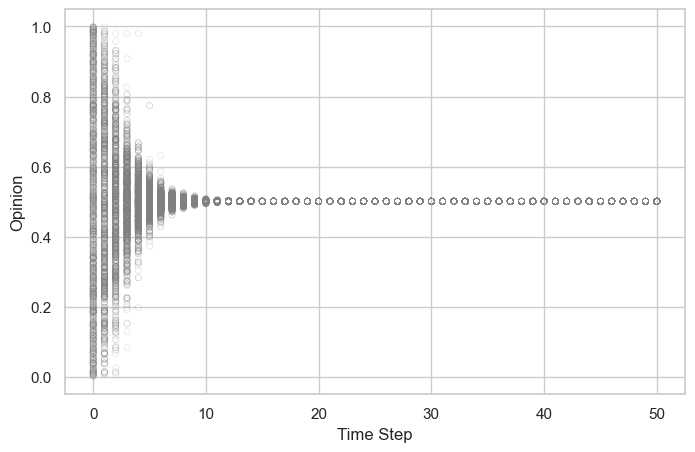

In [269]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.scatterplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), marker='o', s=20, facecolor='none', edgecolor='grey', alpha = 0.3)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

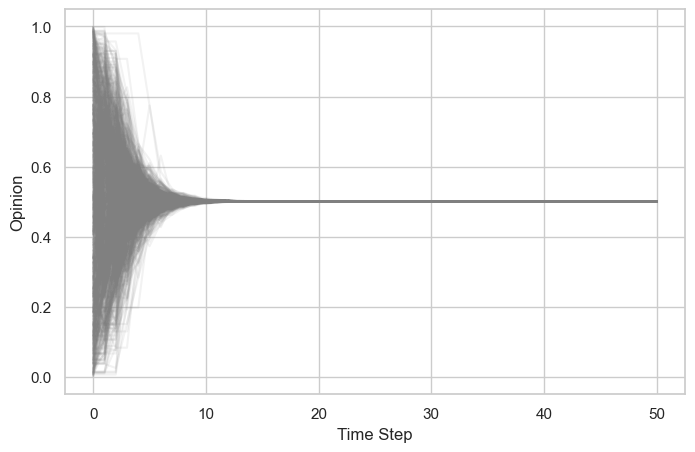

In [271]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

### same data but plot only the first 20 steps

In [272]:
sub_data = agents_data.query('Step <= 20')

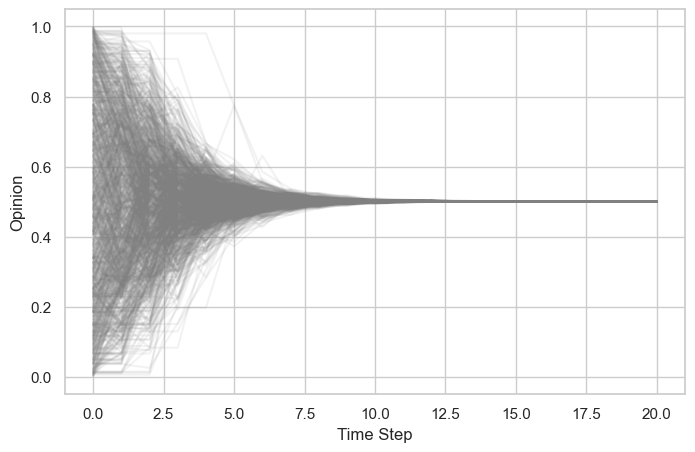

In [274]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = sub_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

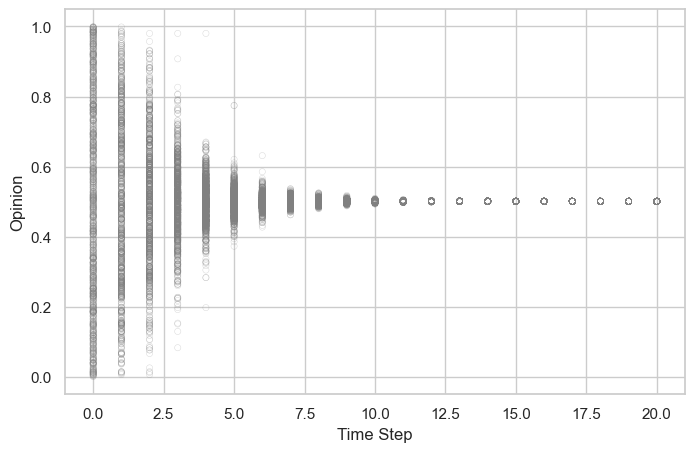

In [273]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.scatterplot(x = "Step", y = "opinion", data = sub_data.query(f"AgentID == {i}"), marker='o', s=20, facecolor='none', edgecolor='grey', alpha = 0.3)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

### Findings:

with d = 0.5, this means that any 2 agents with opinions difference less than 0.5 will go through opinion update process. and eventually after almost 12 steps, all agents opinions will converge into a mid value wihch is 0.5. 

Having a zoomed in look into the first 20 steps. As we can see that the model start with uniformlly distributed initial opinions. 
Then the model reach convergence so that all agents have the opinion (0.5) somewhere between the time steps 11 and 12 

### 2. Opinions over the first 50 steps for 1000 agents (d=0.2)

- N = 1000
- d = 0.2 
- m = 0.5 

In [275]:
model = opinionsModel(N = 1000, d = 0.2, m = 0.5)

In [276]:
num_steps = 50 
for _ in range(num_steps):
    model.step()

In [277]:
agents_data = model.datacollector.get_agent_vars_dataframe()

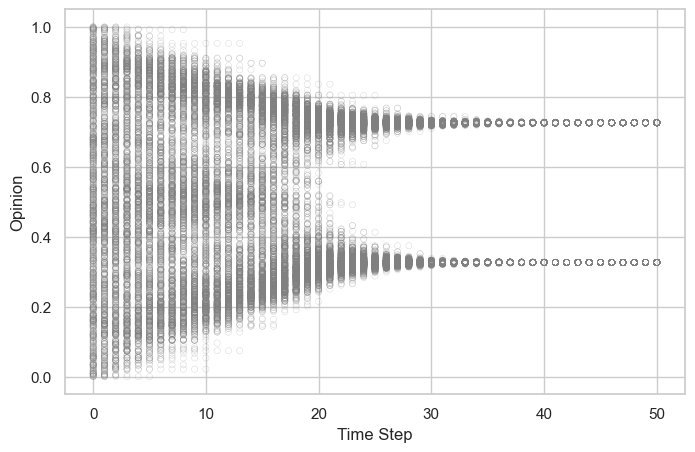

In [278]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.scatterplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), marker='o', s=20, facecolor='none', edgecolor='grey', alpha = 0.3)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

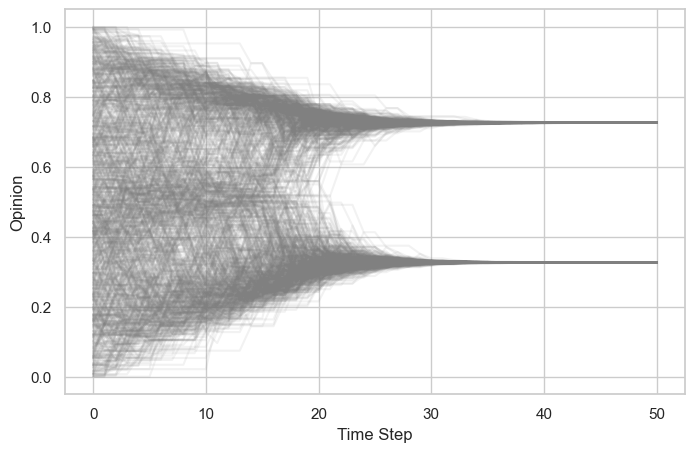

In [279]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

### Understanding this case with a smaller population

In [289]:
m = opinionsModel(N = 10, d = 0.2, m = 0.5)

In [290]:
num_steps = 10 
for _ in range(num_steps):
    m.step()

In [291]:
d = m.datacollector.get_agent_vars_dataframe()

In [292]:
d

opinion
Step AgentID          
0    0        0.060200
     1        0.578730
     2        0.008890
     3        0.389496
     4        0.159874
...                ...
10   5        0.458496
     6        0.458407
     7        0.458460
     8        0.064278
     9        0.458407

[110 rows x 1 columns]

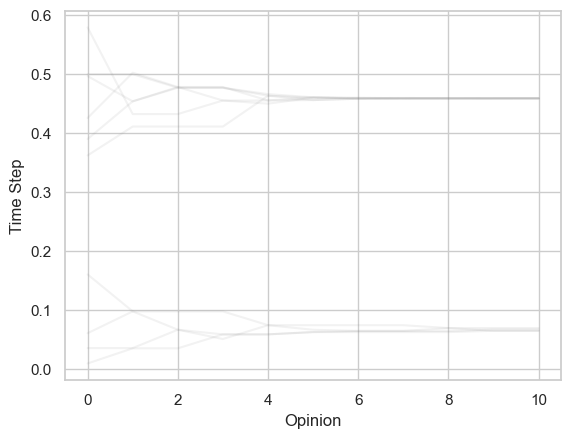

In [294]:
# plt.figure(figsize=(8,  5))

for i in range(m.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = d.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.ylabel("Time Step")
plt.xlabel("Opinion")
plt.show()

In [237]:
d.reset_index(inplace=True)
d = d.pivot_table(index='AgentID', columns='Step', values='opinion')
d.reset_index(inplace=True)

d

Step,AgentID,0,1,2,3,4,5,6,7,8,9,10
0,0,0.077928,0.077928,0.223018,0.223018,0.223018,0.223018,0.223018,0.208821,0.201723,0.201723,0.205272
1,1,0.668985,0.547396,0.493973,0.581455,0.549887,0.565671,0.565671,0.564438,0.559814,0.559814,0.560346
2,2,0.440550,0.440550,0.493973,0.581455,0.565671,0.561725,0.562712,0.562712,0.561263,0.561263,0.560538
3,3,0.489243,0.489243,0.518320,0.518320,0.549887,0.557779,0.557779,0.560492,0.560492,0.560878,0.560346
4,4,0.762800,0.762800,0.668937,0.581455,0.581455,0.565671,0.562712,0.555190,0.561263,0.560878,0.560878
5,5,0.481164,0.575074,0.668937,0.581455,0.565671,0.561725,0.563698,0.564438,0.559814,0.559814,0.560538
6,6,0.279806,0.279806,0.223018,0.194624,0.194624,0.194624,0.194624,0.194624,0.201723,0.201723,0.201723
7,7,0.861324,0.861324,0.861324,0.861324,0.861324,0.861324,0.861324,0.861324,0.861324,0.861324,0.861324
8,8,0.254532,0.254532,0.166230,0.194624,0.194624,0.194624,0.194624,0.208821,0.208821,0.208821,0.205272
9,9,0.519718,0.547396,0.518320,0.518320,0.549887,0.549887,0.549887,0.555190,0.559814,0.559814,0.559814


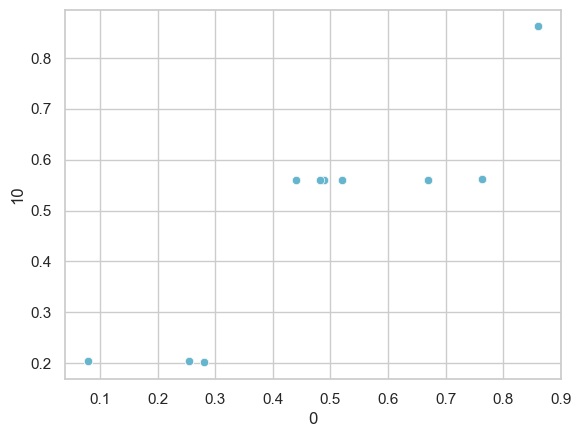

In [239]:
for i in range(m.num_agents):
    sns.scatterplot(x = 0, y = 10, data = d)

# plt.xlabel("Time Step")
# plt.ylabel("Opinion")
plt.show()

### Plotting the final opinions as function of the initial opinions

In [240]:
data = agents_data
data.reset_index(inplace=True)
agent_data_pivoted = data.pivot_table(index='AgentID', columns='Step', values='opinion')
agent_data_pivoted.reset_index(inplace=True)

group_1 = agent_data_pivoted[agent_data_pivoted[50] < 0.5]
group_2 = agent_data_pivoted[agent_data_pivoted[50] > 0.5]

In [241]:
group_1.shape[0] + group_2.shape[0]

1000

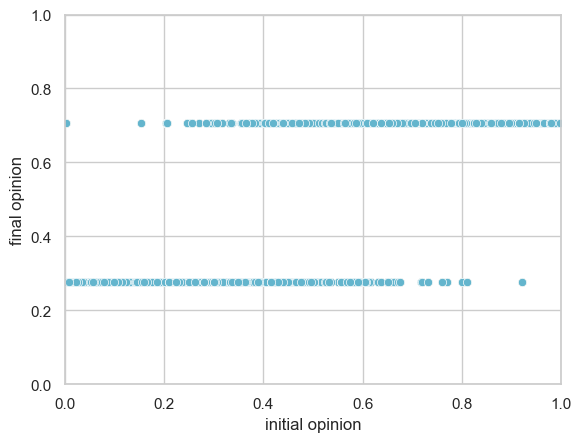

In [295]:
for i in range(model.num_agents):
    sns.scatterplot(x = 0, y = 50, data = agent_data_pivoted)

plt.xlabel("initial opinion")
plt.ylabel("final opinion")

plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

### Findings:

with smaller d, convergence is never reached .. as the author stated "uniformity is only achived for larger values of d.

**Why?** smaller value of d means that only agnets with very close opinions will update their opnions, and the resulting opinion will be close to the  inital opinions. this will cuase the creation of 2 groups of opinions. agents with small inital opinions will be converge to 1 value, and agents with larger initial opinions will converge to another value. 

### Extra case: Opinions over the first 50 steps for 1000 agents (d=0.1)

- N = 1000
- d = 0.1 
- m = 0.5 

In [371]:
model = opinionsModel(N = 1000, d = 0.1, m = 0.5)

In [372]:
num_steps = 50 
for _ in range(num_steps):
    model.step()

In [373]:
agents_data = model.datacollector.get_agent_vars_dataframe()

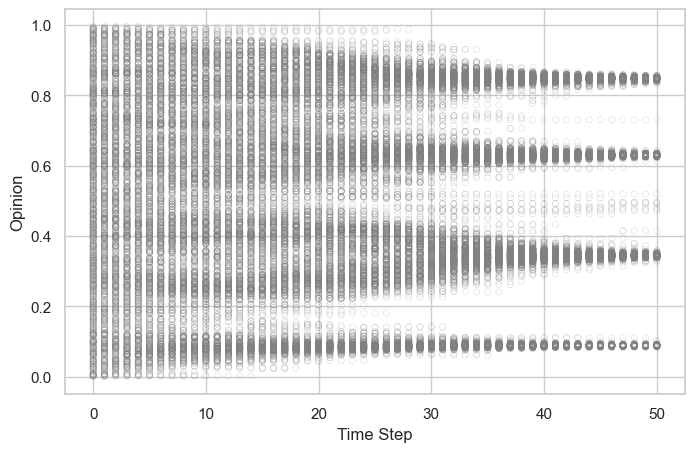

In [374]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.scatterplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), marker='o', s=20, facecolor='none', edgecolor='grey', alpha = 0.3)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

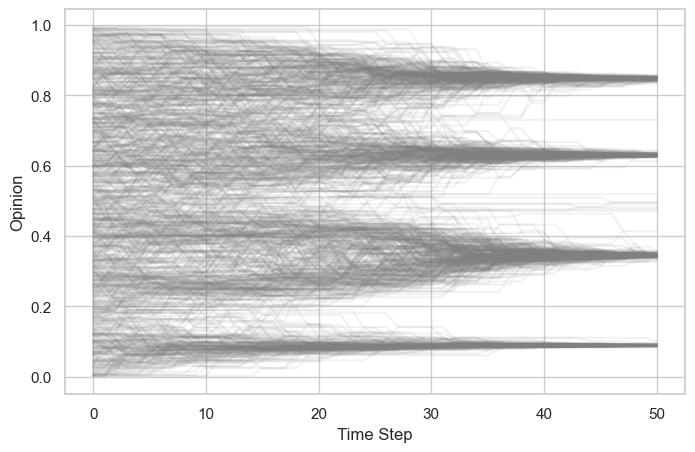

In [376]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

### Findings:

decreasing d further will result in having more converegnce groups

### Extra case: Opinions over the first 50 steps for 1000 agents (d=1)

- N = 1000
- d = 1 
- m = 0.5 

In [296]:
model = opinionsModel(N = 1000, d = 1, m = 0.5)

In [297]:
num_steps = 50 
for _ in range(num_steps):
    model.step()

In [298]:
agents_data = model.datacollector.get_agent_vars_dataframe()

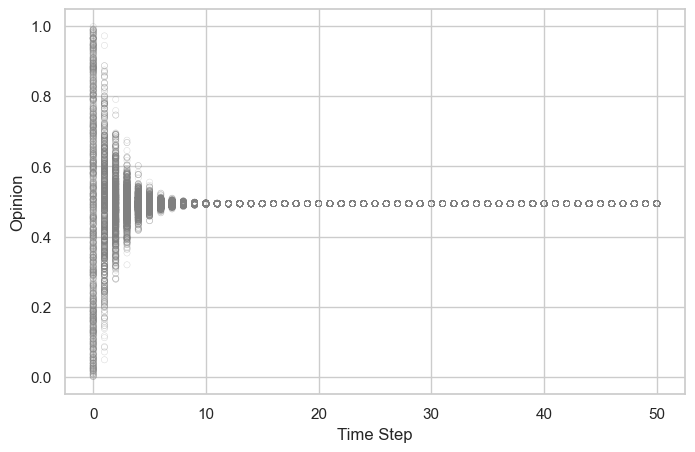

In [300]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.scatterplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), marker='o', s=20, facecolor='none', edgecolor='grey', alpha = 0.3)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

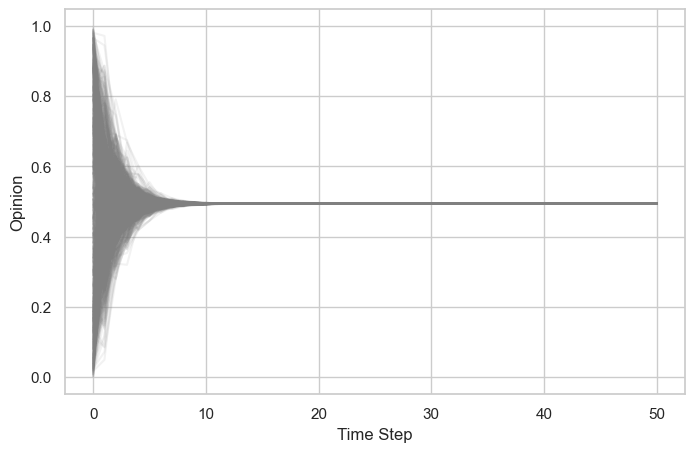

In [299]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

In [301]:
sub_data = agents_data.query('Step <= 20')

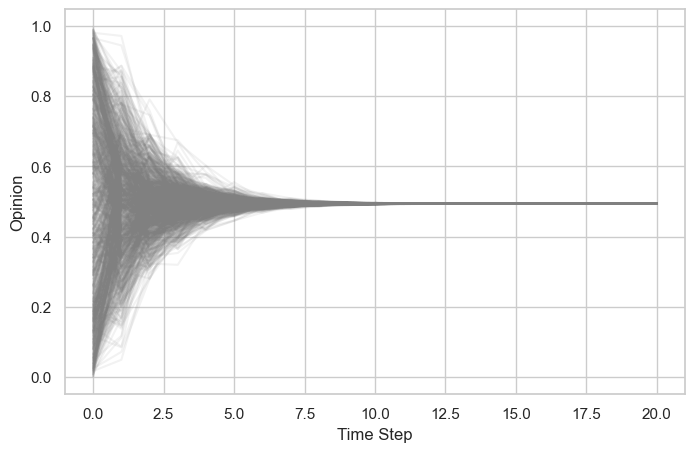

In [302]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = sub_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

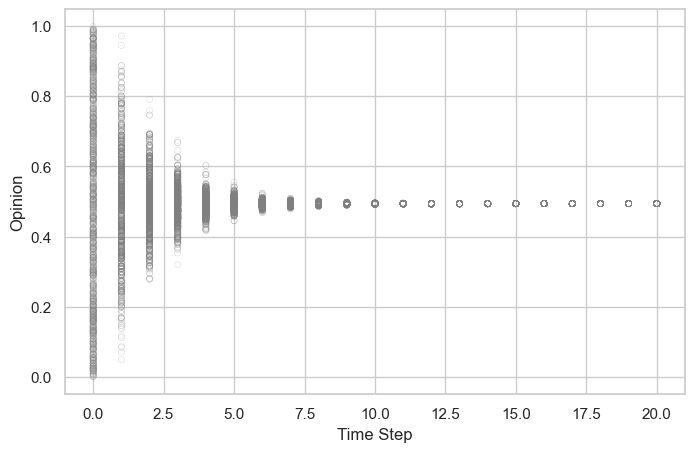

In [303]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.scatterplot(x = "Step", y = "opinion", data = sub_data.query(f"AgentID == {i}"), marker='o', s=20, facecolor='none', edgecolor='grey', alpha = 0.3)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

### Findings: 

In general, increasing the threshold will increase the possiblity for agents to update their opinions. 

In the case of d = 1, it means that almost all agents will update their opinions at every time step, it is like the condition has no purpose. 

But in terms of converence speed, the model reached convergence somewhere around time step 10. So There is no big difference between this and when d was 0.5. But the distribution of opinions is getting narrower at each time step compared to when d was equal to 0.5. 

### Extra case: Opinions over the first 50 steps for 1000 agents (m = 0.2)

- N = 1000
- d = 0.5
- m = 0.2

In [304]:
model = opinionsModel(N = 1000, d = 0.5, m = 0.2)

In [305]:
num_steps = 50 
for _ in range(num_steps):
    model.step()

In [306]:
agents_data = model.datacollector.get_agent_vars_dataframe()

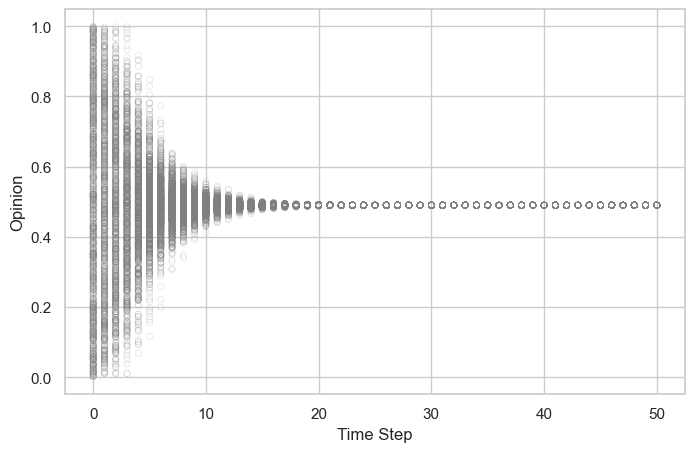

In [307]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.scatterplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), marker='o', s=20, facecolor='none', edgecolor='grey', alpha = 0.3)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

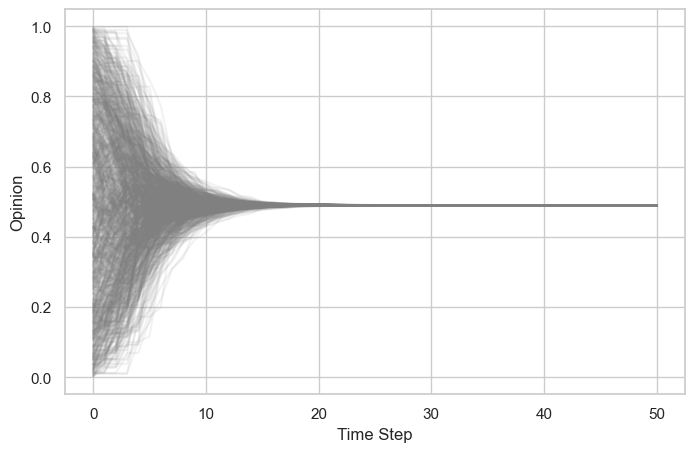

In [308]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

### Findings: 

lower m values will result in a slower model converence, as the model in this case took someting neer 20 time steps to convereg. 

This is because m is the converegnce parameter, its role is to adjust the value that will be used to update the agent opinion. having small m values will result in small affect (reduction or amplification) on the added value. while larger will result in bigger affect. 

example: let x = 0.4 and x' = 0.7
- no m -> O = 0.4 + (0.7 - 0.4) = 0.7 
- m = 0.5 -> O = 0.4 + 0.5 * (0.7 - 0.4) = 0.4 + 0.15 = 0.55
- m = 0.2 -> O = 0.4 + 0.2 * (0.7 - 0.4) = 0.4 + 0.06 = 0.46 


That's why the convergence speed got slower when we decreased the value of m, because the agents are now using smaller values in updating their opinions compared to when m was 0.5. 

### Extra case: Opinions over the first 50 steps for 1000 agents (m = 0.9)

- N = 1000
- d = 0.5
- m = 0.9

In [366]:
model = opinionsModel(N = 1000, d = 0.5, m = 0.9)

In [367]:
num_steps = 50 
for _ in range(num_steps):
    model.step()

In [368]:
agents_data = model.datacollector.get_agent_vars_dataframe()

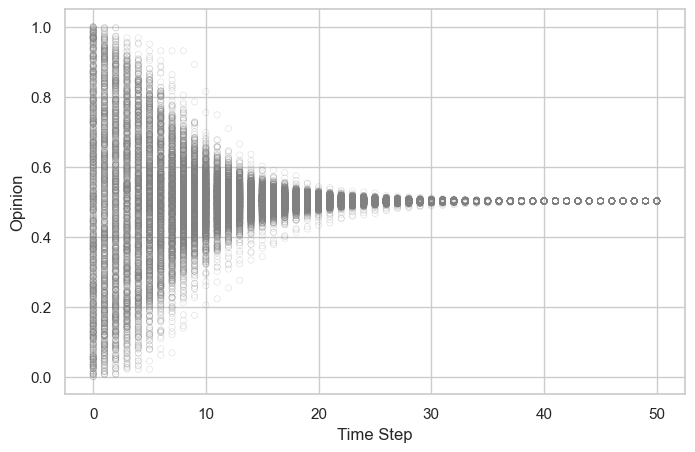

In [369]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.scatterplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), marker='o', s=20, facecolor='none', edgecolor='grey', alpha = 0.3)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

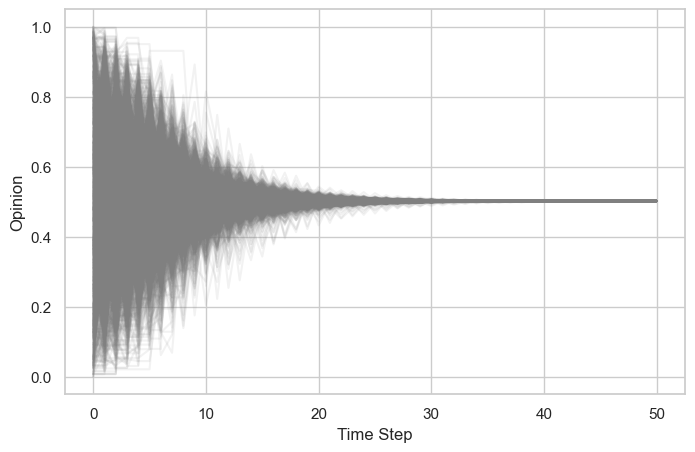

In [370]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

### Findings: 

when m is large and close to 1, this meanse that the opinions will be updated by large values causing a lot of bounces in values (as we see in the second figure). Which will result in increasing the convergence time to something around 35 